Data Exploration and Understanding for Train Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def optimize_memory(df):
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'object':  # For string-based data
            df[col] = df[col].astype('category')
    return df

chunks = []
train_dataset = r"C:\Users\THIRU\OneDrive\Desktop\project_4\GUIDE_Train.csv"
# Read the dataset in chunks and process each chunk
for chunk in pd.read_csv(train_dataset, chunksize=500000,low_memory=False):
    chunk = optimize_memory(chunk)
    chunks.append(chunk)

# Concatenate all chunks into a single DataFrame
df = pd.concat(chunks, ignore_index=True)

# Clean up memory
del chunks
df.head()

,Id,OrgId,IncidentId,AlertId,Timestamp,DetectorId,AlertTitle,Category,MitreTechniques,IncidentGrade,...,ResourceType,Roles,OSFamily,OSVersion,AntispamDirection,SuspicionLevel,LastVerdict,CountryCode,State,City
0,1786,0,612,123247,2024-06-04T06:05:15.000Z,7,6,InitialAccess,NaN,TruePositive,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,31.0,6.0,3.0
1,1492,88,326,210035,2024-06-14T03:01:25.000Z,58,43,Exfiltration,NaN,FalsePositive,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0
2,2573,809,58352,712507,2024-06-13T04:52:55.000Z,423,298,InitialAccess,T1189,FalsePositive,...,NaN,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0
3,4528,92,32992,774301,2024-06-10T16:39:36.000Z,2,2,CommandAndControl,NaN,BenignPositive,...,NaN,NaN,5.0,66.0,NaN,Suspicious,Suspicious,242.0,1445.0,10630.0
4,3722,148,4359,188041,2024-06-15T01:08:07.000Z,9,74,Execution,NaN,TruePositive,...,NaN,NaN,5.0,66.0,NaN,NaN,NaN,242.0,1445.0,10630.0


In [2]:
# shape of the dataset
df.shape

(5620872, 45)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5620872 entries, 0 to 5620871
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  int32   
 1   OrgId               int32   
 2   IncidentId          int32   
 3   AlertId             int32   
 4   Timestamp           object  
 5   DetectorId          int32   
 6   AlertTitle          int32   
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       category
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            int32   
 15  Sha256              int32   
 16  IpAddress           int32   
 17  Url                 int32   
 18  AccountSid          int32   
 19  AccountUpn          int32   
 20  AccountObjectId     int32   
 21  AccountName         float64 
 22  DeviceName          float64 
 23  NetworkMessageId    float64 
 24

In [4]:
# Check for missing values
df.isnull().sum()

Id                          0
OrgId                       0
IncidentId                  0
AlertId                     0
Timestamp                   0
DetectorId                  0
AlertTitle                  0
Category                    0
MitreTechniques       3229436
IncidentGrade           30239
ActionGrouped         5587907
ActionGranular        5587907
EntityType                  0
EvidenceRole                0
DeviceId                    0
Sha256                      0
IpAddress                   0
Url                         0
AccountSid                  0
AccountUpn                  0
AccountObjectId             0
AccountName                 1
DeviceName                  1
NetworkMessageId            1
EmailClusterId        5563642
RegistryKey                 1
RegistryValueName           1
RegistryValueData           1
ApplicationId               1
ApplicationName             1
OAuthApplicationId          1
ThreatFamily          5576768
FileName                    1
FolderPath

In [5]:
# Check for duplicate rows
duplicate_count = df.duplicated().sum()
duplicate_count 

np.int64(9337)

In [6]:
# Target variable distribution
df['IncidentGrade'].value_counts()

IncidentGrade
BenignPositive    2427523
TruePositive      1963560
FalsePositive     1199550
Name: count, dtype: int64

Data Cleaning and Preprocessing for Train Dataset

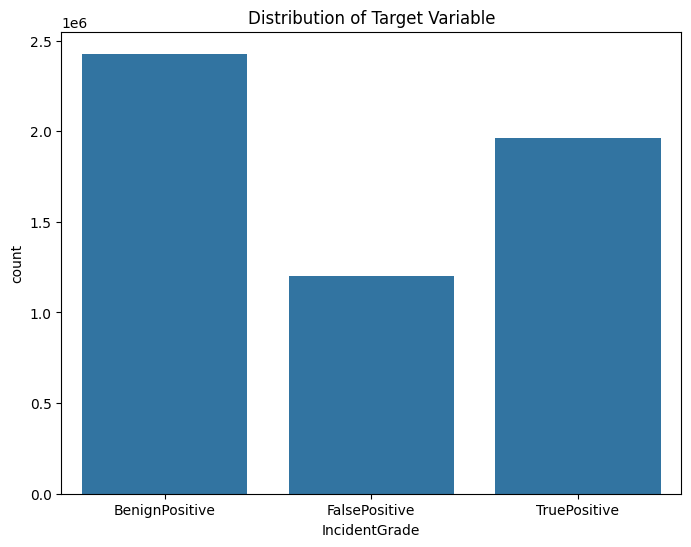

In [7]:
# plot Distribution of Target Variable
plt.figure(figsize=(8, 6))
sns.countplot(x=df['IncidentGrade'])
plt.title('Distribution of Target Variable')
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Calculate the percentage of missing values for each column
missing_percentage = df.isnull().sum() / len(df) * 100

# List columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
print("Columns with more than 50% missing values are dropped")

# Drop these columns
df.drop(columns=columns_to_drop, axis=1, inplace=True)

Columns with more than 50% missing values are dropped


In [9]:
# Impute missing values for categorical columns
categorical_columns = df.select_dtypes(include=['object','category']).columns
for col in categorical_columns:
    if df[col].isnull().any():
        mode_val = df[col].mode()[0]
        df[col] = df[col].fillna(mode_val)
        print(f"Imputed categorical column '{col}' with mode value: {mode_val}")

Imputed categorical column 'IncidentGrade' with mode value: BenignPositive


In [10]:
# Impute missing values for numeric columns
numeric_columns = df.select_dtypes(include=['int32','float32']).columns
for col in numeric_columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)
        print(f"Imputed numeric column '{col}' with median value: {median_val}")

In [11]:
def outliers(df, iqr_multiplier=1.5):
    numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64', 'float64'])
    for col in numeric_features.columns:
        if df[col].nunique() > 10:
            Q1 = numeric_features[col].quantile(0.25)
            Q3 = numeric_features[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - iqr_multiplier * IQR
            upper_bound = Q3 + iqr_multiplier * IQR   
            df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Usage
df = outliers(df, iqr_multiplier=1.5) 

In [12]:
id_columns = ['Id', 'OrgId', 'IncidentId', 'AlertId', 'DetectorId', 'DeviceId', 'Sha256', 
              'IpAddress', 'Url', 'AccountSid', 'AccountUpn', 'AccountObjectId', 'AccountName', 
              'DeviceName', 'NetworkMessageId',  'RegistryKey', 'RegistryValueName', 
              'RegistryValueData', 'ApplicationId', 'ApplicationName', 'OAuthApplicationId', 
              'FileName', 'FolderPath', 'ResourceIdName','OSFamily', 'OSVersion', 'City','CountryCode', 'State']

# Exclude ID columns from scaling
numeric_features = df.select_dtypes(include=['int32', 'int16', 'float32', 'int64']).drop(columns=id_columns, errors='ignore')

# Scaling numerical features 
scaler = MinMaxScaler()
df[numeric_features.columns] = scaler.fit_transform(numeric_features)

In [13]:
# categorical columns
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Convert to string if necessary

In [14]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [ ]:
# Save
path = r"C:\Users\THIRU\OneDrive\Desktop\project_4\train_cleaned_dataset.csv"
df.to_csv(path, index=False)
print("Data preprocessing complete and saved.")